# LIBRARIES

In [15]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# DATASET PREPARATION & CONFIGURATION

In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
data_dir = "C:/Users/USER/Documents/project P/glaucoma_dataset"
batch_size = 16
num_classes = 2
num_epochs = 20
img_size = 224
learning_rate = 3e-4
patience = 5  # for early stopping

# ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# Split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [8]:
print(total_size)
print(train_size)
print(val_size)
print(test_size)

1172
937
117
118


# DATA VISUALIZATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7865399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.9988013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2009804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6152923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1529241].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6666666].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.24

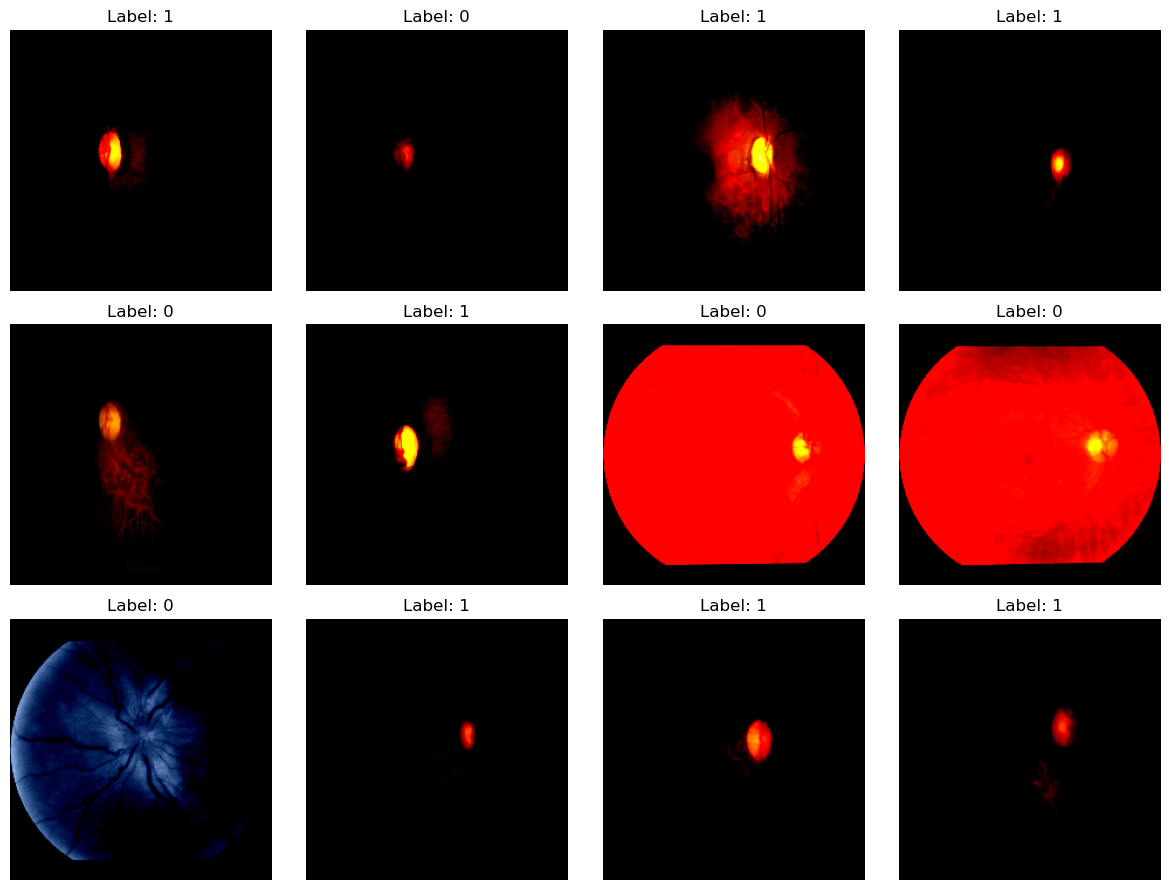

In [10]:
# Get one batch from your DataLoader
images, labels = next(iter(train_loader))

# Display first 12 images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i in range(12):
    img = images[i].permute(1, 2, 0)  # Convert CHW to HWC
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f'Label: {labels[i].item()}')
    axes[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

# MODEL TRAINING & OPTIMIZATION

In [12]:
# Model setup
model = models.resnet50(weights='DEFAULT')  # Updated: using weights instead of pretrained
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Early stopping
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # --- Training phase ---
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")
    
    # --- Validation phase ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu())
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    scheduler.step(avg_val_loss)
    
    # --- Early stopping check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_resnet50_fundus_model.pth")
        print("Model improved and saved.")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("⏹️ Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_wts)


Epoch 1/20
Train Loss: 0.3923
Validation Loss: 0.4313, Accuracy: 0.8376
Model improved and saved.

Epoch 2/20
Train Loss: 0.2748
Validation Loss: 0.3392, Accuracy: 0.8291
Model improved and saved.

Epoch 3/20
Train Loss: 0.1792
Validation Loss: 0.7775, Accuracy: 0.7179

Epoch 4/20
Train Loss: 0.1450
Validation Loss: 0.3510, Accuracy: 0.8120

Epoch 5/20
Train Loss: 0.0835
Validation Loss: 0.2432, Accuracy: 0.8718
Model improved and saved.

Epoch 6/20
Train Loss: 0.0789
Validation Loss: 0.2698, Accuracy: 0.8803

Epoch 7/20
Train Loss: 0.0683
Validation Loss: 0.3642, Accuracy: 0.8205

Epoch 8/20
Train Loss: 0.0649
Validation Loss: 0.2625, Accuracy: 0.8718

Epoch 9/20
Train Loss: 0.0245
Validation Loss: 0.4015, Accuracy: 0.8718

Epoch 10/20
Train Loss: 0.0124
Validation Loss: 0.4200, Accuracy: 0.8974
⏹️ Early stopping triggered.


<All keys matched successfully>

# MODEL EVALUATION & PERFORMANCE METRICS


Final Test Accuracy: 0.8814

🧾 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        63
           1       0.84      0.93      0.88        55

    accuracy                           0.88       118
   macro avg       0.88      0.88      0.88       118
weighted avg       0.89      0.88      0.88       118



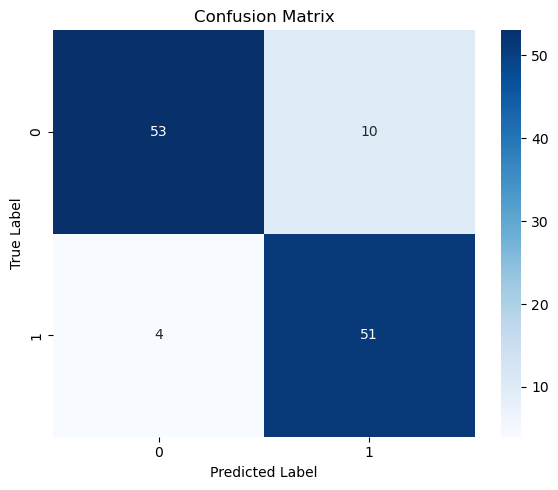

In [17]:
# --- Test evaluation ---
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu()
        test_preds.extend(preds)
        test_labels.extend(labels)

test_acc = accuracy_score(test_labels, test_preds)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


# --- Confusion matrix and classification report ---
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_names)

print("\n🧾 Classification Report:")
print(report)

# --- Plot confusion matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## Classes Names: ['Glaucoma', 'Normal']
## Number of Classes: 2
## Number of Normal Images: 586
## Number of Glaucoma Positive Images: 586

## Train Shape: (937, 2)

## Validation Shape: (117, 2)

## Test Shape: (118, 2)

# TRAINING HISTORY VISUALIZATION

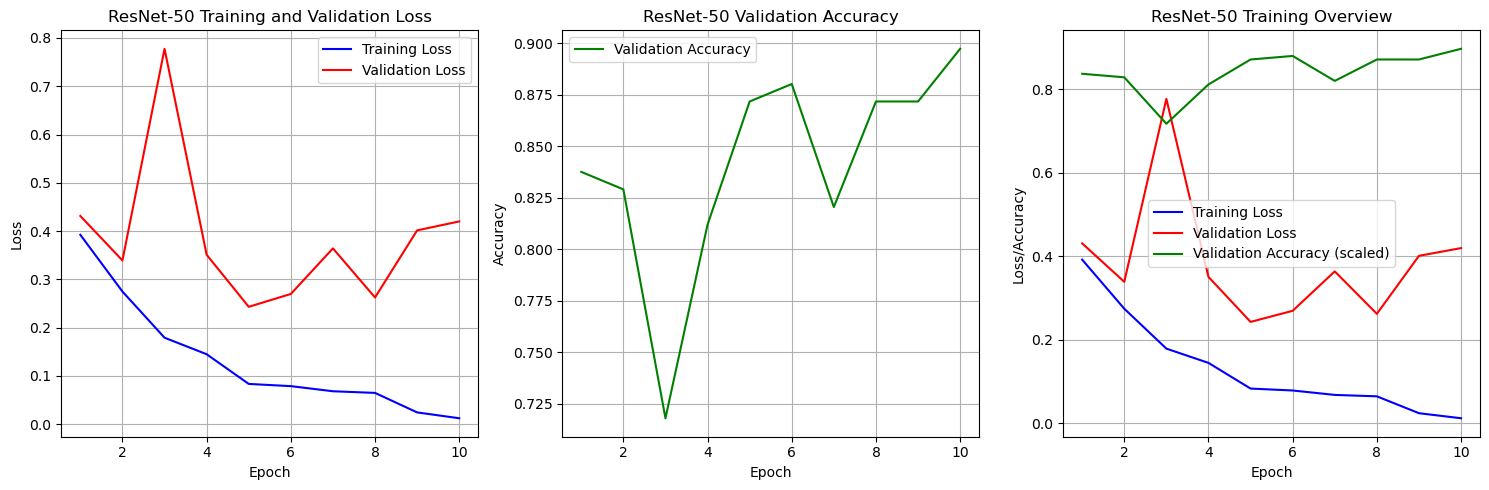

In [15]:
resnet_train_losses = [0.3923, 0.2748, 0.1792, 0.1450, 0.0835, 0.0789, 0.0683, 0.0649, 0.0245, 0.0124]

resnet_val_losses = [0.4313, 0.3392, 0.7775, 0.3510, 0.2432, 0.2698, 0.3642, 0.2625, 0.4015, 0.4200]

resnet_val_accuracies = [0.8376, 0.8291, 0.7179, 0.8120, 0.8718, 0.8803, 0.8205, 0.8718, 0.8718, 0.8974]

# Plot ResNet-50 training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 11), resnet_train_losses, 'b-', label='Training Loss')
plt.plot(range(1, 11), resnet_val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet-50 Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, 11), resnet_val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet-50 Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
epochs = range(1, 11)
plt.plot(epochs, resnet_train_losses, 'b-', label='Training Loss')
plt.plot(epochs, resnet_val_losses, 'r-', label='Validation Loss')
plt.plot(epochs, resnet_val_accuracies, 'g-', label='Validation Accuracy (scaled)')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('ResNet-50 Training Overview')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()